#**ETUDE DE MARCHÉ**

# **Notebook 2/2 - Clustering CAH et K-means - Visualisation - PCA**  


# Contexte

La poule qui chante, une entreprise française d’agroalimentaire souhaite se développer à l'international.
Une première analyse des groupements de pays à cibler pour exporter des poulets est requise.

Une étude de marché plus approfondie sera menée ultérieurement.





Un dataframe composé de 9 variables a été préparé dans le Notebook 1/2.


**IMPORTATION DES LIBRAIRIES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer


#1 - IMPORT ET PREPARATION DU DF

In [3]:
file_path1 = '/content/df.csv'
df = pd.read_csv(file_path1)
df = df.set_index('Zone')
df.head()

,EoDB,PIB_par_habitant,Polulation,Coefficient de croissance,ratio quantité volaille,Disponibilité volaille,Exportations - Quantité,Importations - Quantité,Production
Zone,,,,,,,,,
Afghanistan,38.94,530.1,36296.113,0.79,0.15,1.53,0.0,29.0,28.0
Afrique du Sud,65.41,6723.9,57009.756,0.29,0.52,35.69,63.0,514.0,1667.0
Albanie,64.16,4521.8,2884.169,-0.08,0.28,16.36,0.0,38.0,13.0
Algérie,46.11,4134.9,41389.189,0.36,0.28,6.38,0.0,2.0,275.0
Allemagne,79.55,44670.2,82658.409,0.02,0.20,19.47,646.0,842.0,1514.0


In [4]:
# Application d'une fonction log pour les 4 variables très dispersées
df_log=df.copy()

df_log['PIB_par_habitant'] = round(np.log1p(df_log['PIB_par_habitant']), 2)# log PIB
df_log = df_log.rename(columns={'PIB_par_habitant': 'Log(PIB)'})# Renommer la colonne

df_log['Polulation'] = round(np.log1p(df_log['Polulation']), 2)# log population
df_log = df_log.rename(columns={'Polulation': 'Log(Population)'})# Renommer la colonne

df_log['Exportations - Quantité'] = round(np.log1p(df_log['Exportations - Quantité']), 2)# log Exportations
df_log = df_log.rename(columns={'Exportations - Quantité': 'Log(Exportations)'})# Renommer la colonne

df_log['Production'] = round(np.log1p(df_log['Production']), 2)# log Production
df_log = df_log.rename(columns={'Production': 'Log(Production)'})# Renommer la colonne



In [5]:
# Simplification du libéllés des autres variables
df_log=df_log.rename(columns={'ratio quantité volaille'	: 'ratio_volaille'} )
df_log=df_log.rename(columns={'Disponibilité volaille (kg/personne/an)':'Dispo_volaille'} )
df_log=df_log.rename(columns={'Coefficient de croissance':'Coef_croissance'} )
df_log=df_log.rename(columns={'Importations - Quantité'	: 'Importations'} )


In [6]:
df_log.head()

,EoDB,Log(PIB),Log(Population),Coef_croissance,ratio_volaille,Disponibilité volaille,Log(Exportations),Importations,Log(Production)
Zone,,,,,,,,,
Afghanistan,38.94,6.27,10.50,0.79,0.15,1.53,0.00,29.0,3.37
Afrique du Sud,65.41,8.81,10.95,0.29,0.52,35.69,4.16,514.0,7.42
Albanie,64.16,8.42,7.97,-0.08,0.28,16.36,0.00,38.0,2.64
Algérie,46.11,8.33,10.63,0.36,0.28,6.38,0.00,2.0,5.62
Allemagne,79.55,10.71,11.32,0.02,0.20,19.47,6.47,842.0,7.32


#2 -CLUSTERING

## - 2.1 Définition des fonctions

In [7]:
#Kmeans - clusters labels - centroids
def cluster_labels_and_centroids(x, n_clusters):

    """ Applique l'algorithme K-means et retourne un array avec les labels des clusters et un array avec les centroids.

    Paramètres:
    x (pd.DataFrame ou np.ndarray): Les données à clusteriser.
    n_clusters (int): Le nombre de clusters.

    Retourne:
    tuple: Un tuple contenant deux éléments:
        - cluster_labels (np.ndarray): Un array des labels des clusters.
        - centroids (np.ndarray): Un array des centroids"""

    # On instancie le Kmeans avec le nombre de clusters spécifié et random_state=42 :
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    # On l'entraine sur les données :
    kmeans.fit(x)

    # On stocke les clusters dans une variable labels :
    cluster_labels = kmeans.labels_

    # On stocke les centroids dans une variable centroids :
    centroids = kmeans.cluster_centers_

    return cluster_labels, centroids

In [8]:
# Lister les pays des clusters identifiés
def print_cluster_composition(df, num_clusters):

    ''' Etablit la liste des index en fonction de leur cluster_label.

    Paramètres:
    df (pd.DataFrame): Le dataframe des données contenant la variable 'Cluster'.
    num_clusters (int): Le nombre de clusters.

    Retourne:
    None: La fonction imprime les listes des index pour chaque cluster et le nombre d'éléments dans chaque liste.'''

    for i in range(num_clusters):
        cluster_list = df[df['Cluster'] == i].index.tolist()
        print(f'Cluster {i}')
        print(cluster_list)
        print(f'Nombre d\'éléments dans le cluster : {len(cluster_list)}')

In [9]:
# Graphique countplot de répartition des clusters
def plot_cluster_repartition(df):

    ''' Affiche un graphique countplot de répartition des clusters.

    Paramètres:
    df (pd.DataFrame): Le dataframe des données contenant la variable 'Cluster'.

    Bibliothèque: seaborn as sns

    Retourne:
    None: affiche le graphique'''

    plt.figure(figsize=(6,5))
    plt.title('Répartition des pays par cluster')
    sns.countplot(data=df, x='Cluster')
    plt.xlabel("Cluster Kmeans")
    plt.ylabel("Effectif")
    plt.show()

In [10]:
# Créer un radar plot pour chaque centroid
def radar_centroids (array_centroids,df_des_centroids):

    ''' Affiche le graphique radar de centroids déterminés par méthode de clustring.

    Paramètres:
    array_centroids (np.array): Un array des centroids
    df_des_centroids (pd.DataFrame): Le dataframe des centroids avec les noms des caractéristiques en colonnes

    Bibliothèque: plotly.graph_objects as go

    Retourne:
    None: affiche le graphique'''

    fig = go.Figure()
    for i, centroid_k in enumerate(array_centroids):
        fig.add_trace(go.Scatterpolar(
           r=centroid_k,
           theta=df_des_centroids.columns,
           fill='toself',
           name=f'Cluster {i}' ))

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True),),
        showlegend=True)

    fig.show()

## 2.2 - Classification hiérarchique - Dendogramme

### 2.2.1 - Calcul et affichage du Dendrogramme

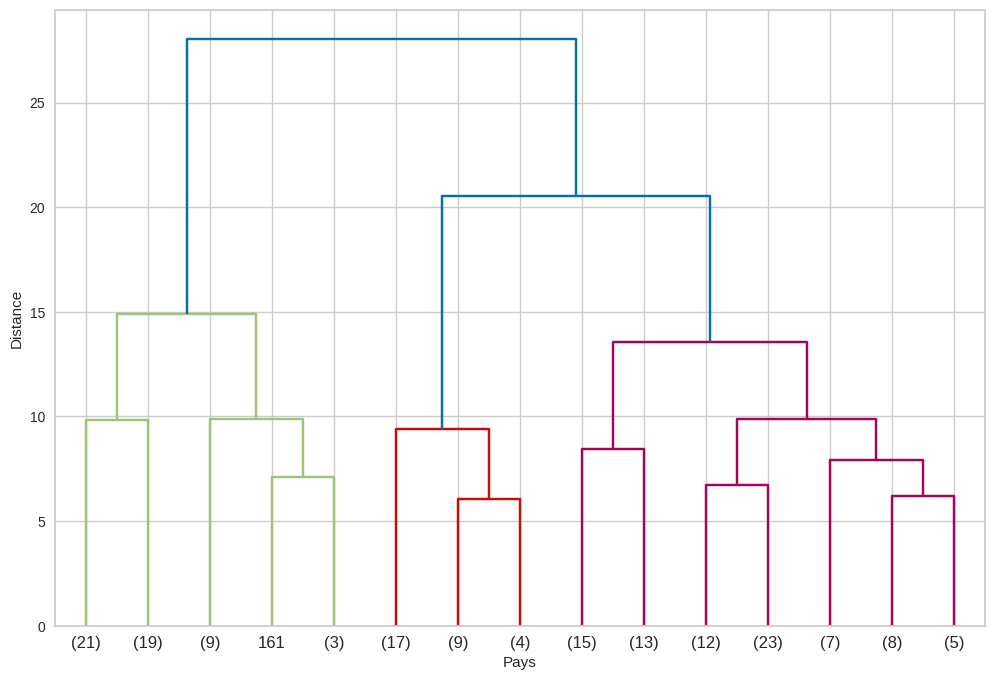

In [11]:
X = df_log.copy()

# Instencier le StandardScaler
scaler = StandardScaler()

# Normalisation les données
X_scaled = scaler.fit_transform(X)

# Affichage du dendrogramme
plt.figure(figsize=(12, 8))
plt.xlabel("Pays")
plt.ylabel("Distance")

dendrogram = sch.dendrogram(sch.linkage(X_scaled, method = 'ward'), p=15,truncate_mode="lastp")

On peut choisir de travailler sur les 3 clusters identifiés.

### 2.2.2 - Analyse des clusters

In [12]:
# Appliquer l'algorithme de clustering
clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')
cluster_labels_ACH = clustering.fit_predict(X_scaled)

# Attribuer un identifiant à chaque cluster
df_ACH = df_log.copy()
df_ACH['Cluster'] = cluster_labels_ACH


In [13]:
# Composition des clusters
print_cluster_composition(df_ACH, 3)

Cluster 0
['Afrique du Sud', 'Allemagne', 'Arabie saoudite', 'Argentine', 'Australie', 'Autriche', 'Belgique', 'Brésil', 'Bulgarie', 'Bélarus', 'Canada', 'Chili', 'Chine - RAS de Hong-Kong', 'Chine, Taiwan Province de', 'Chine, continentale', 'Croatie', 'Danemark', 'Espagne', 'Estonie', 'Finlande', 'France', 'Fédération de Russie', 'Grèce', 'Hongrie', "Iran (République islamique d')", 'Iraq', 'Irlande', 'Italie', 'Japon', 'Kazakhstan', 'Lettonie', 'Lituanie', 'Malaisie', 'Mexique', 'Norvège', 'Nouvelle-Zélande', 'Pays-Bas', 'Pologne', 'Portugal', 'Roumanie', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'République de Corée', 'Serbie', 'Slovaquie', 'Slovénie', 'Suisse', 'Suède', 'Tchéquie', 'Thaïlande', 'Turquie', 'Ukraine', 'Émirats arabes unis', "États-Unis d'Amérique"]
Nombre d'éléments dans le cluster : 53
Cluster 1
['Afghanistan', 'Algérie', 'Angola', 'Azerbaïdjan', 'Bangladesh', 'Bolivie (État plurinational de)', 'Bosnie-Herzégovine', 'Botswana', 'Burkina Faso', 'Bénin',

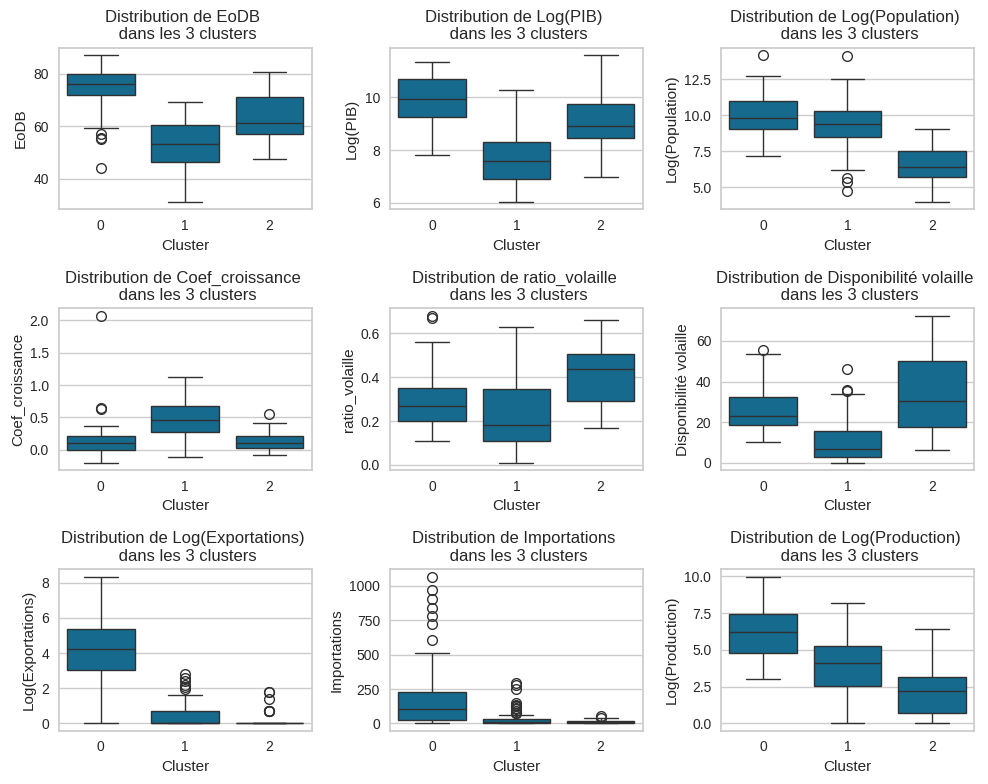

In [14]:
# Distribution des variables au sein des 3 cluters identifiés
liste_variables = df_log.columns.tolist()


plt.figure(figsize=(10, 8))
# Boucle sur chaque variable
for i, var in enumerate(liste_variables, start=1):
    plt.subplot(3, 3,i)  # Créer un subplot
    sns.boxplot(data=df_ACH, x='Cluster', y=var)  # Tracer un box plot pour chaque variable
    plt.title(f'Distribution de {var} \n dans les 3 clusters')

plt.tight_layout()
plt.show()


**Cluster 0** / 53 pays

PIB/habitant et  EoDB élevés. Production, Importation et Exportation elévées
Population élevée, faible croissance.
Disponibilité en volaille importante, ratio intermédiaire.
Ce sont les Pays riches.

**Cluster 1** / 83 pays
PIB/habitant et  EoDB très bas. Production moyenne et import export faible
population élevée et croissance la plus forte.
Disponibilité en volaille et ratio  plus faible que les autres.
Pays à éviter.

**Cluster 2** / 30 pays
PIB/habitant et  EoDB intermédiare. Production la plus faible et Import Export très bas.
Population et Croissance faible.
Disponibilité en volaille et ratio élevée.


In [15]:
# Calcul des centroids de l'ACH
centroids_ACH = []
for label in np.unique(cluster_labels_ACH):
    cluster_points = X_scaled[cluster_labels_ACH == label]
    centroid = np.mean(cluster_points, axis=0)
    centroids_ACH.append(centroid)

centroids_ACH = np.array(centroids_ACH)

In [16]:
# Convertir les centroids en DataFrame
centroids_dfACH = pd.DataFrame(centroids_ACH, columns=df_log.columns)


In [17]:
# Créer un radar plot pour chaque centroid
radar_centroids (centroids_ACH,centroids_dfACH)

##2.3 - K-means

###2.3.1 - Nombre de clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

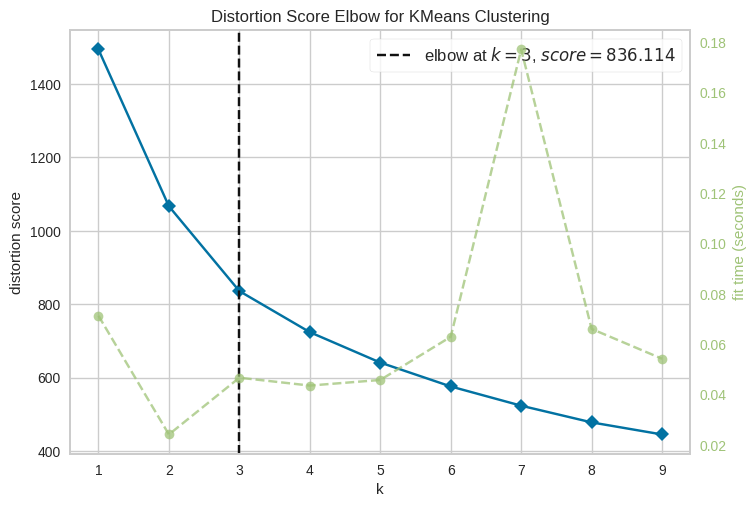

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
# On instancie  le modèle de clustering et le visualiseur
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(X_scaled)
visualizer.show()

--> Le nombre de clusters optimal est de 3

###2.3.2 - Application de l'algorithme K-means

In [19]:
# Utilisation de la fonction Kmeans - composition des clusters
cluster_labels_k, centroids_k = cluster_labels_and_centroids(X_scaled, 3)
cluster_labels_k

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([1, 2, 0, 1, 2, 1, 0, 2, 2, 0, 2, 2, 0, 0, 1, 0, 2, 0, 0, 0, 1, 2,
       2, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 1, 0, 2, 1, 2, 1, 0, 0,
       2, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 1, 1, 0, 0, 1, 0, 2, 1, 1,
       2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 1, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 1,
       2, 1, 1, 1, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1,
       1, 1, 0, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 2, 1, 2, 2, 1, 1, 2, 0, 2, 1, 1, 1, 2, 2, 1, 1, 0, 0, 2, 2, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1], dtype=int32)

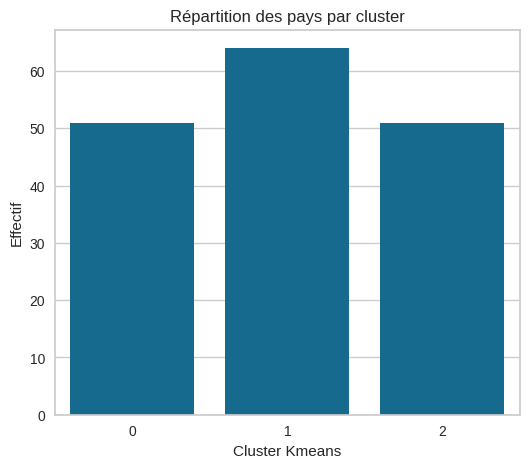

In [20]:
# On ajoute les labels des clusters au df
df_k = df_log.copy()
df_k['Cluster'] = cluster_labels_k


# graphique de répartition des pays par cluster
plot_cluster_repartition(df_k)

In [21]:
#Utilisation de la fonction print_cluster_composition
print_cluster_composition(df_k, 3)

Cluster 0
['Albanie', 'Antigua-et-Barbuda', 'Arménie', 'Azerbaïdjan', 'Bahamas', 'Barbade', 'Belize', 'Bolivie (État plurinational de)', 'Bosnie-Herzégovine', 'Cabo Verde', 'Chypre', 'Costa Rica', 'Dominique', 'El Salvador', 'Estonie', 'Fidji', 'Gabon', 'Grenade', 'Guatemala', 'Guyana', 'Géorgie', 'Honduras', 'Iraq', 'Islande', 'Israël', 'Jamaïque', 'Jordanie', 'Koweït', 'Luxembourg', 'Macédoine du Nord', 'Malte', 'Maroc', 'Maurice', 'Monténégro', 'Namibie', 'Nicaragua', 'Norvège', 'Oman', 'Panama', 'République de Moldova', 'République dominicaine', 'Saint-Kitts-et-Nevis', 'Saint-Vincent-et-les Grenadines', 'Sainte-Lucie', 'Samoa', 'Suriname', 'Trinité-et-Tobago', 'Tunisie', 'Uruguay', 'Émirats arabes unis', 'Équateur']
Nombre d'éléments dans le cluster : 51
Cluster 1
['Afghanistan', 'Algérie', 'Angola', 'Bangladesh', 'Botswana', 'Burkina Faso', 'Bénin', 'Cambodge', 'Cameroun', 'Congo', "Côte d'Ivoire", 'Djibouti', 'Eswatini', 'Gambie', 'Ghana', 'Guinée', 'Guinée-Bissau', 'Haïti', 'Ind

--> On obtient 3 clusters qui semblent équilibrés

### 2.3.3 - Analyses des centroides

In [22]:
centroids_k

array([[ 0.12328871,  0.33070404, -0.79571461, -0.09382454,  0.88215571,
         0.68770787, -0.40563283, -0.26442059, -0.46476258],
       [-0.85977666, -0.96023374,  0.21479189,  0.60622525, -0.72610946,
        -0.87272418, -0.67195691, -0.31760082, -0.34402113],
       [ 0.9556467 ,  0.87429516,  0.52617185, -0.66692871,  0.02904048,
         0.40747541,  1.24887287,  0.66297849,  0.89647537]])

In [23]:
# Convertir les centroids en DataFrame
centroids_df = pd.DataFrame(centroids_k, columns=df_log.columns)
centroids_df.head()

,EoDB,Log(PIB),Log(Population),Coef_croissance,ratio_volaille,Disponibilité volaille,Log(Exportations),Importations,Log(Production)
0,0.123289,0.330704,-0.795715,-0.093825,0.882156,0.687708,-0.405633,-0.264421,-0.464763
1,-0.859777,-0.960234,0.214792,0.606225,-0.726109,-0.872724,-0.671957,-0.317601,-0.344021
2,0.955647,0.874295,0.526172,-0.666929,0.029040,0.407475,1.248873,0.662978,0.896475


In [24]:
# Créer un radar plot pour chaque centroid avec la fonction radar_centroids
radar_centroids (centroids_k,centroids_df)

**Cluster 2** /  51 pays (53 en ACH)

PIB/habitant et EoDB élevés. Production, Importation et Exportation elévées :
il y a un gros marché déjà en place.

Disponibilité en volaille importante, mais consomme aussi d'autres viandes (ratio < dispo ).

Population élevée mais croissance faible.

Marché intéressant mais concurentiel ?

**Cluster 1** / 64 pays (83 en ACH)

PIB et EoDB très bas. Production et importation faibles, sensiblement équivalentes au cluster 0 . Pas d'exportation.

Dispo par habitant faible

Population importante, juste un peu en dessous de cluster 2, et en forte croissance.

Pays à éviter !

**Cluster 0** / 51 pays (30 en ACH)

PIB/habitant et EoDB moyens. Production, Importation et Exportation faibles

Disponibilité en volaille importante avec un ratio élevé, la volaille est une source de viande principale.

Population faible mais avec une bonne croissance
A creuser ?


.

Text(70.72222222222221, 0.5, 'cluster')

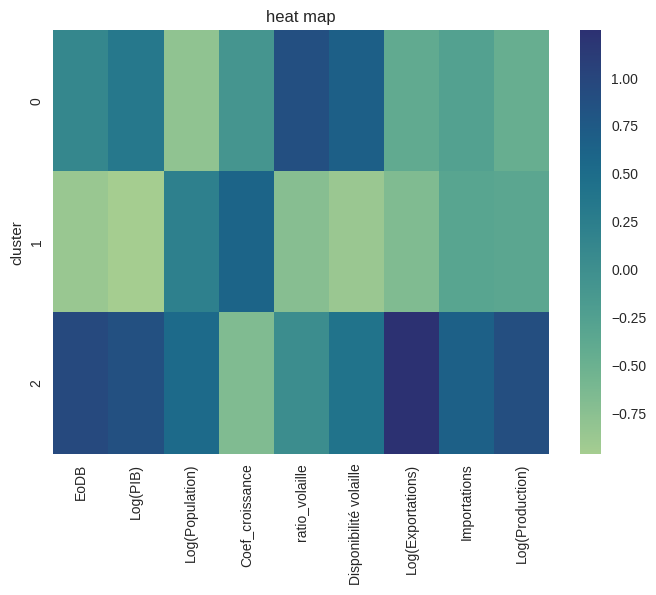

In [25]:
# Heat map sur les centroids des clusters

sns.heatmap(centroids_df, cmap="crest")
plt.title('heat map')
plt.xlabel('')
plt.ylabel('cluster')

On retrouve sur cette visualisation les caractéristiques identifiées sur le graphique en radar.

## 2.4 - Comparaison ACH et K-means

###2.4.1 - Score de silhouette  


Le score de silhouette évalue la cohésion et la séparation des clusters:

Pour chaque point de données on calcule:

s(i)= (b(i) - a(i)) /max{a(i),b(i)}

où :

s(i) est le score de silhouette du point

a(i) est la cohésion intra-cluster du point

b(i) est la séparation inter-cluster du point

La moyenne des s(i) est le score de silhouette global de l'algorithme de clustering.

In [26]:
from sklearn.metrics import silhouette_score

In [27]:
# Calcul du score de silhouette pour le K-means
silhouette_score_K = silhouette_score(X_scaled, cluster_labels_k)
print("Score de silhouette pour K-means avec 3 clusters:", round(silhouette_score_K,3))


Score de silhouette pour K-means avec 3 clusters: 0.276


In [28]:
# Calcul du score de silhouette pour l'ACH
silhouette_score_ACH = silhouette_score(X_scaled, cluster_labels_ACH)
print("Score de silhouette pour l'ACH avec 3 clusters:", round(silhouette_score_ACH,3))

Score de silhouette pour l'ACH avec 3 clusters: 0.257


--> Les clusters obtenus par le K-means semblent légèrement mieux définis que ceux de l'ACH

###2.4.2 - Visualisation des projections des clusters et centroids

In [29]:
# Instancier et ajuster PCA
pca = PCA(n_components=3)
pca.fit(X_scaled)

PCA(n_components=3)

In [30]:
# Projeter les données d'origine sur les composantes principales
X_proj = pca.transform(X_scaled)
X_proj = pd.DataFrame(X_proj, columns = ["F1", "F2", "F3"])

##### **Calcul des projections ACH**

In [31]:
# Calcul des centroids de l'ACH
centroids_ACH = []
for label in np.unique(cluster_labels_ACH):
    cluster_points = X_scaled[cluster_labels_ACH == label]
    centroid = np.mean(cluster_points, axis=0)
    centroids_ACH.append(centroid)

centroids_ACH = np.array(centroids_ACH)


In [32]:
# On utilise  le scaler déjà entrainé :
centroids_scaled_ACH = scaler.fit_transform(centroids_ACH)

# et on utilise l'ACP déjà entrainée :
centroids_proj_ACH = pca.transform(centroids_scaled_ACH)

# Création d'un dataframe
centroids_proj_ACH= pd.DataFrame(centroids_proj_ACH,
                              columns = ["F1", "F2", "F3"],
                              index=["cluster_0", "cluster_1", "cluster_2"])


##### **Calcul des projections K-means**

In [33]:
# On utilise  le scaler déjà entrainé :
centroids_scaled_k = scaler.fit_transform(centroids_k)

# et on utilise l'ACP déjà entrainée :
centroids_proj_k = pca.transform(centroids_scaled_k)



In [34]:
# Création d'un dataframe
centroids_proj_k = pd.DataFrame(centroids_proj_k,
                              columns = ["F1", "F2", "F3"],
                              index=["cluster_0", "cluster_1", "cluster_2"])

##### **Visualisation des projections**


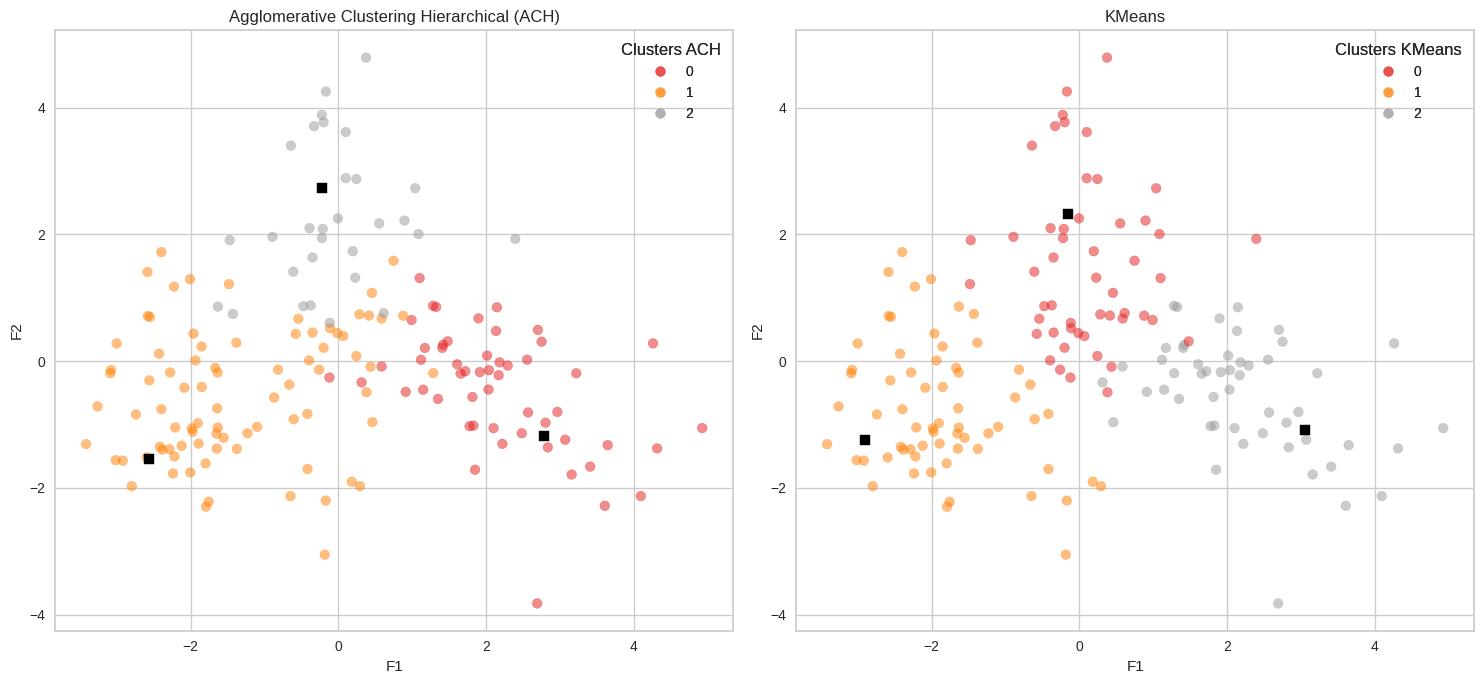

In [35]:
# Créer une figure et une grille de sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Graphique pour l'Agglomerative Clustering Hierarchical (ACH)
scatter_ACH = axes[0].scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c=cluster_labels_ACH, cmap="Set1", alpha=0.5)
axes[0].scatter(centroids_proj_ACH.iloc[:, 0], centroids_proj_ACH.iloc[:, 1], marker="s", c="black")
axes[0].set_title('Agglomerative Clustering Hierarchical (ACH)')
axes[0].set_xlabel("F1")
axes[0].set_ylabel("F2")

# Graphique pour le KMeans
scatter_kmeans = axes[1].scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c=cluster_labels_k, cmap="Set1", alpha=0.5)
axes[1].scatter(centroids_proj_k.iloc[:, 0], centroids_proj_k.iloc[:, 1], marker="s", c="black")
axes[1].set_title('KMeans')
axes[1].set_xlabel("F1")
axes[1].set_ylabel("F2")

# Ajouter une légende pour les deux graphiques
legend_ACH = axes[0].legend(*scatter_ACH.legend_elements(), title="Clusters ACH")
axes[0].add_artist(legend_ACH)
legend_kmeans = axes[1].legend(*scatter_kmeans.legend_elements(), title="Clusters KMeans")
axes[1].add_artist(legend_kmeans)

plt.tight_layout()
plt.show()


--> On retrouve sensiblement les mêmes clusters selon les 2 méthodes :

*  0/ACH et 2/K-means = pays riches
*  1/ACH et 1/K-means = pays pauvres
*  2/ACH et 0/K-means = pays intermédiaires

On confirme cependant que les clusters K_means sont légèrement mieux définis que ceux de l'ACH.




Les listes de pays obtenus sont cependant encore trop longues.
On va poursuivre l'analyse en appliquant un 2ème K-means sur le cluster des pays intermédiaires pour voir si ceux qui présentent les meilleures caractéristiques pourraient être de bons candidats.

## 2.5 - Poursuite de l'analyse sur les clusters identifiés par K-means

### 2.5.1 - Cluster 0 (pays intermédiaires)

In [36]:
# kmeans sur le clusterk = 0
X0=df_k[df_k['Cluster']==0]
X0=X0[X0.columns[:-1]]

In [37]:
# Normaliser les données
X0_scaled = scaler.fit_transform(X0)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

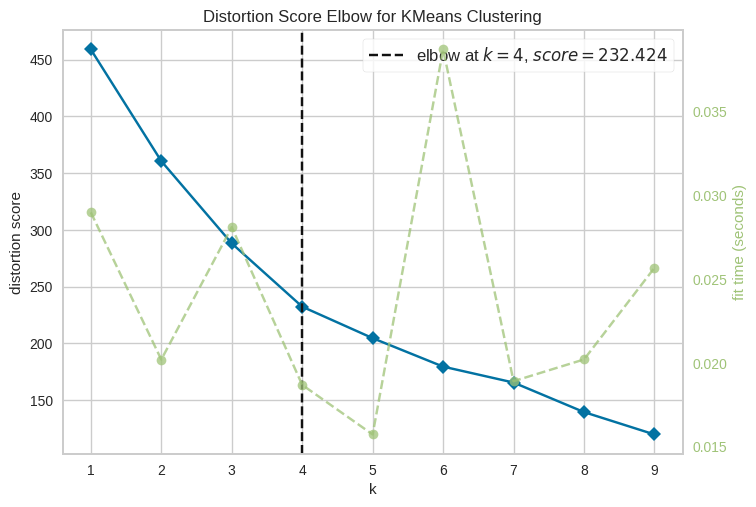

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
# On instancie  le modèle de clustering et le visualiseur
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(X0_scaled)
visualizer.show()

In [39]:
# Utilisation de la fonction Kmeans - composition des clusters
cluster_labels_k0, centroids_k0 = cluster_labels_and_centroids(X0_scaled, 4)
cluster_labels_k

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([1, 2, 0, 1, 2, 1, 0, 2, 2, 0, 2, 2, 0, 0, 1, 0, 2, 0, 0, 0, 1, 2,
       2, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 1, 0, 2, 1, 2, 1, 0, 0,
       2, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 1, 1, 0, 0, 1, 0, 2, 1, 1,
       2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 1, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 1,
       2, 1, 1, 1, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1,
       1, 1, 0, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 2, 1, 2, 2, 1, 1, 2, 0, 2, 1, 1, 1, 2, 2, 1, 1, 0, 0, 2, 2, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1], dtype=int32)

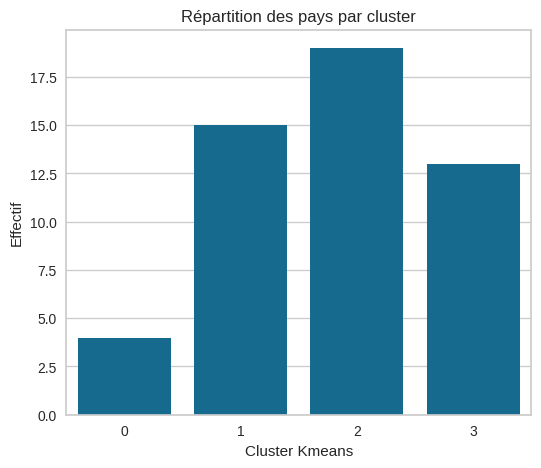

In [40]:
# On ajoute les labels des clusters au df
X0['Cluster'] = cluster_labels_k0

# graphique de répartition des pays par cluster
plot_cluster_repartition(X0)

In [41]:
# Utilisation de la fonction print_cluster_composition
print_cluster_composition(X0, 4)

Cluster 0
['Iraq', 'Koweït', 'Oman', 'Émirats arabes unis']
Nombre d'éléments dans le cluster : 4
Cluster 1
['Antigua-et-Barbuda', 'Bahamas', 'Barbade', 'Belize', 'Cabo Verde', 'Dominique', 'Gabon', 'Grenade', 'Guyana', 'Saint-Kitts-et-Nevis', 'Saint-Vincent-et-les Grenadines', 'Sainte-Lucie', 'Samoa', 'Suriname', 'Trinité-et-Tobago']
Nombre d'éléments dans le cluster : 15
Cluster 2
['Albanie', 'Arménie', 'Azerbaïdjan', 'Bosnie-Herzégovine', 'Chypre', 'Costa Rica', 'Estonie', 'Fidji', 'Géorgie', 'Islande', 'Luxembourg', 'Macédoine du Nord', 'Malte', 'Maurice', 'Monténégro', 'Namibie', 'Norvège', 'République de Moldova', 'Uruguay']
Nombre d'éléments dans le cluster : 19
Cluster 3
['Bolivie (État plurinational de)', 'El Salvador', 'Guatemala', 'Honduras', 'Israël', 'Jamaïque', 'Jordanie', 'Maroc', 'Nicaragua', 'Panama', 'République dominicaine', 'Tunisie', 'Équateur']
Nombre d'éléments dans le cluster : 13


In [42]:
centroids_k0

array([[-0.10496521,  0.72169894,  0.96697105,  2.53053142,  0.8672548 ,
         0.04535781,  1.46324277,  2.82680529,  0.21084809],
       [-0.78729382,  0.03246783, -1.14440898, -0.19878379,  0.43610527,
         0.88217925, -0.60810288, -0.2902294 , -0.94098285],
       [ 0.78963219,  0.22804238,  0.01956   , -0.50206747, -0.94419921,
        -0.67946998, -0.01322845, -0.24988135, -0.13348911],
       [-0.21336489, -0.59281681,  0.99435465,  0.18453177,  0.60993744,
        -0.03878388,  0.27076251, -0.16969495,  1.21597257]])

In [43]:
# On convertit les centroids en DataFrame
centroids_df0 = pd.DataFrame(centroids_k0, columns=df.columns)
centroids_df0.head()

,EoDB,PIB_par_habitant,Polulation,Coefficient de croissance,ratio quantité volaille,Disponibilité volaille,Exportations - Quantité,Importations - Quantité,Production
0,-0.104965,0.721699,0.966971,2.530531,0.867255,0.045358,1.463243,2.826805,0.210848
1,-0.787294,0.032468,-1.144409,-0.198784,0.436105,0.882179,-0.608103,-0.290229,-0.940983
2,0.789632,0.228042,0.019560,-0.502067,-0.944199,-0.679470,-0.013228,-0.249881,-0.133489
3,-0.213365,-0.592817,0.994355,0.184532,0.609937,-0.038784,0.270763,-0.169695,1.215973


In [44]:
# Créer un radar plot pour chaque centroid avec la fonction radar_centroids
radar_centroids (centroids_k0,centroids_df0)

Le cluster 0 est celui qui se démarque avec la plus grande surface: importation et croissance maximale. Cependant l'index EoDB est trop bas. Il contient 4 pays : 'Iraq', 'Koweït', 'Oman', 'Émirats arabes unis'. Il ne semble  pas pernitent les retenir comme candidats.

Les autres clusters ne présentent pas de carartéristiques intéressantes.


Le choix semble donc s'orienter vers le cluster 2 des pays riches. Pour ce cluster aussi on peut aplliquer un 2 ème K_means pour sélectionner les meilleurs candidats.


###2.5.2 - Cluster 2 (pays riches)


In [45]:
# kmeans sur le clusterk =2
X2=df_k[df_k['Cluster']==2]
X2=X2[X2.columns[:-1]]

In [46]:
# Initialiser le StandardScaler
scaler = StandardScaler()

# Normaliser les données
X2_scaled = scaler.fit_transform(X2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

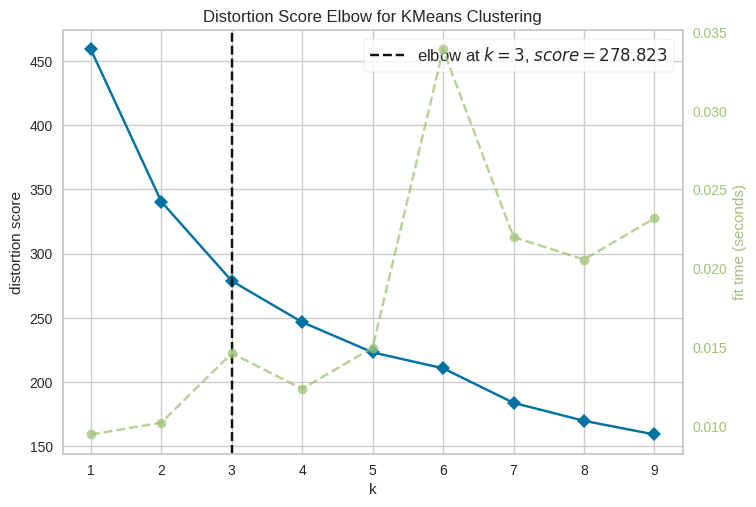

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
# On instancie  le modèle de clustering et le visualiseur
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(X2_scaled)
visualizer.show()

In [48]:
# Utilisation de la fonction Kmeans - composition des clusters
cluster_labels_k2, centroids_k2 = cluster_labels_and_centroids(X2_scaled, 3)
cluster_labels_k2

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([0, 2, 0, 0, 2, 1, 2, 0, 1, 1, 2, 0, 2, 1, 2, 0, 1, 1, 2, 1, 2, 2,
       1, 1, 0, 1, 2, 2, 1, 1, 1, 0, 0, 1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 0, 0, 2], dtype=int32)

In [49]:
# On ajoute les labels des clusters au df
X2['Cluster'] = cluster_labels_k2

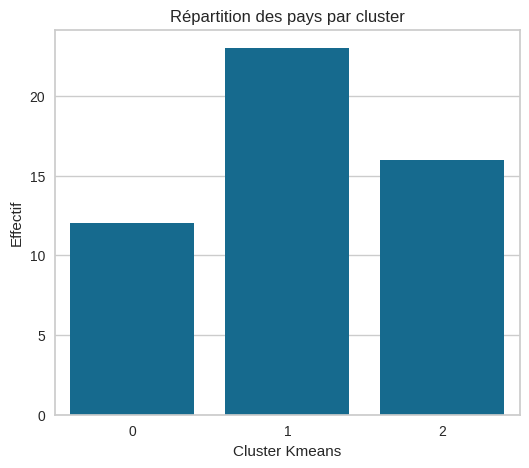

In [50]:
plot_cluster_repartition(X2)

In [51]:
# # Utilisation de la fonction print_cluster_composition
print_cluster_composition(X2, 3)

Cluster 0
['Afrique du Sud', 'Arabie saoudite', 'Argentine', 'Brésil', 'Chili', 'Colombie', "Iran (République islamique d')", 'Malaisie', 'Mexique', 'Pérou', 'Turquie', 'Ukraine']
Nombre d'éléments dans le cluster : 12
Cluster 1
['Autriche', 'Bulgarie', 'Bélarus', 'Chine, Taiwan Province de', 'Croatie', 'Danemark', 'Finlande', 'Grèce', 'Hongrie', 'Irlande', 'Kazakhstan', 'Lettonie', 'Lituanie', 'Nouvelle-Zélande', 'Portugal', 'Roumanie', 'République de Corée', 'Serbie', 'Slovaquie', 'Slovénie', 'Suisse', 'Suède', 'Tchéquie']
Nombre d'éléments dans le cluster : 23
Cluster 2
['Allemagne', 'Australie', 'Belgique', 'Canada', 'Chine - RAS de Hong-Kong', 'Chine, continentale', 'Espagne', 'France', 'Fédération de Russie', 'Italie', 'Japon', 'Pays-Bas', 'Pologne', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Thaïlande', "États-Unis d'Amérique"]
Nombre d'éléments dans le cluster : 16


In [52]:
centroids_k2

array([[-1.19768985, -0.96620785,  0.61733919,  1.00479335,  1.33935749,
         0.57329118, -0.16373537,  0.04314091,  0.71695974],
       [ 0.37236168,  0.14825748, -0.81178877, -0.50976229, -0.49789616,
        -0.43353896, -0.50443715, -0.48460176, -0.82321059],
       [ 0.36299747,  0.51153575,  0.70394197, -0.02081173, -0.28879239,
         0.19324387,  0.84792994,  0.66425935,  0.64564541]])

In [53]:
# On convertit les centroids en DataFrame
centroids_df2 = pd.DataFrame(centroids_k2, columns=df_log.columns)
centroids_df2.head()

,EoDB,Log(PIB),Log(Population),Coef_croissance,ratio_volaille,Disponibilité volaille,Log(Exportations),Importations,Log(Production)
0,-1.197690,-0.966208,0.617339,1.004793,1.339357,0.573291,-0.163735,0.043141,0.716960
1,0.372362,0.148257,-0.811789,-0.509762,-0.497896,-0.433539,-0.504437,-0.484602,-0.823211
2,0.362997,0.511536,0.703942,-0.020812,-0.288792,0.193244,0.847930,0.664259,0.645645


In [54]:
# Créer un radar plot pour chaque centroid avec la fonction radar_centroids
radar_centroids (centroids_k2,centroids_df2)

On trouve effectivemnt un sous_cluster beaucoup plus intérressant , le cluster 1 avec un PIB par habitant et un index EoDB maximum ainsi qu'un marché, représenté par les 3 variables production importations exportations, maximum aussi.

il est composé de 15 pays :

'Chine - RAS de Hong-Kong', 'Pays-Bas', 'Pologne', 'Allemagne', 'Australie', 'Canada', 'Chine, continentale', 'Espagne', 'France', 'Fédération de Russie', 'Italie', 'Japon', 'Mexique', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", "États-Unis d'Amérique".




On peut maintenant envisager le volet environnemental de l'analyse Pestel et choisir les pays les plus proches pour diminuer l'emprunte carbone ainsi que ceux faisant parti de l'Union Européeene pour des raisons de facilité de déplacement.  


On peut alors restreindre la liste à 5 pays :

Pays-Bas, Pologne, Allemagne, Espagne, Italie.


###2.5.3 Visualisation des pays avec la bibliothèque GEOPANDAS

In [55]:
pip install geopandas matplotlib

<ipython-input-56-e1ccfd5a9b69>:26: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



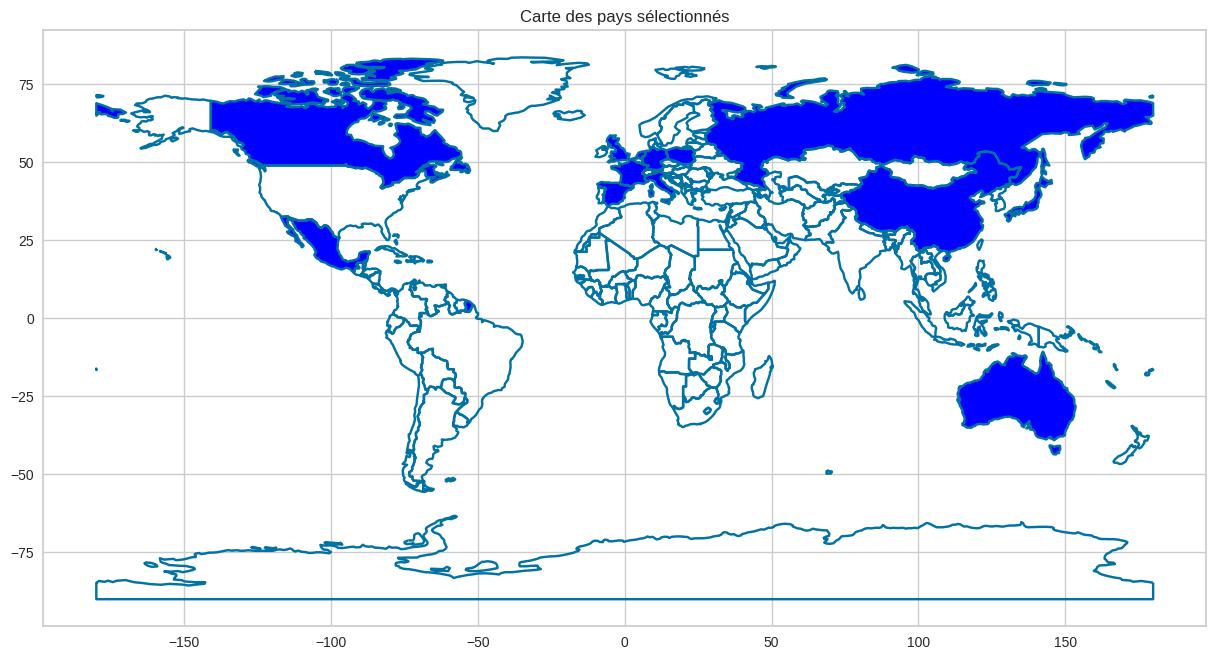

In [56]:
import geopandas as gpd


# Créer le dataframe pandas avec les noms des pays en anglais
pays = [
    "Hong Kong",
    "Netherlands",
    "Poland",
    "Germany",
    "Australia",
    "Canada",
    "China",
    "Spain",
    "France",
    "Russia",
    "Italy",
    "Japan",
    "Mexico",
    "United Kingdom",
    "United States"
]

df = pd.DataFrame({'country': pays})

# Charger les données géographiques mondiales
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filtrer les pays dans le GeoDataFrame world en utilisant les noms des pays en anglais
filtered_world = world[world['name'].isin(df['country'])]

# Tracer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
filtered_world.plot(ax=ax, color='blue')
plt.title('Carte des pays sélectionnés')
plt.show()



<ipython-input-57-623c737cffc7>:12: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



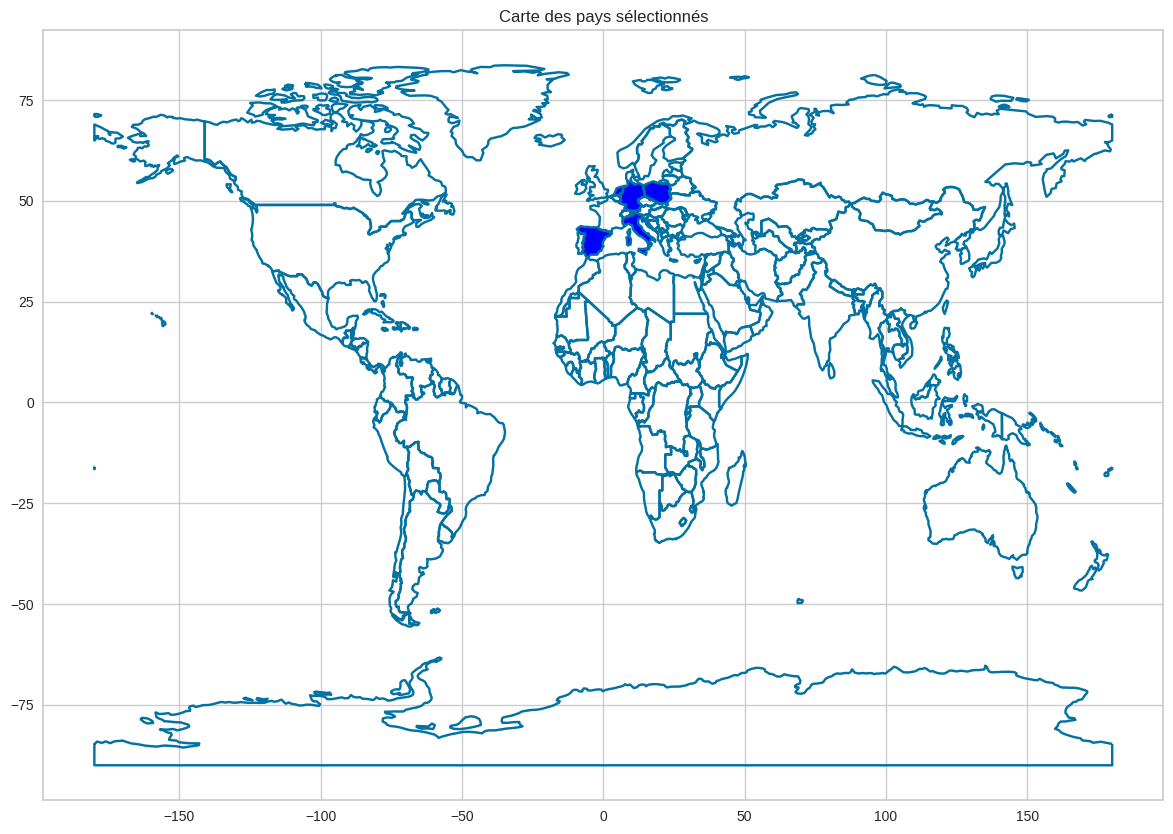

In [57]:
# Créer le dataframe pandas avec les 5 pays
pays_5 = [
    "Netherlands",
    "Poland",
    "Germany",
    "Spain",
    "Italy"]

df5 = pd.DataFrame({'country': pays_5})

# Charger les données géographiques mondiales
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filtrer les pays dans le GeoDataFrame world en utilisant les noms des pays en anglais
filtered_world = world[world['name'].isin(df5['country'])]

# Tracer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
filtered_world.plot(ax=ax, color='blue')
plt.title('Carte des pays sélectionnés')
plt.show()

#3 - Etude des corrélations entre les variables et projections des individus par PCA

On repart des données de la partie, soit les données déjà scalées : X3_scaled

In [58]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7,8
mean,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Les données sont bien centrées réduites.

On détermine le nombre d'axes à analyser par le graphique d'Eboulis des valeurs propres.

##3.1 - Eboulis des valeurs propres

In [59]:
n_components = 6
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=6)

In [60]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([39.59, 23.9 , 13.47,  9.  ,  5.91,  3.36])

In [61]:
scree_cum = scree.cumsum().round()
scree_cum

array([40., 63., 77., 86., 92., 95.])

In [62]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6]

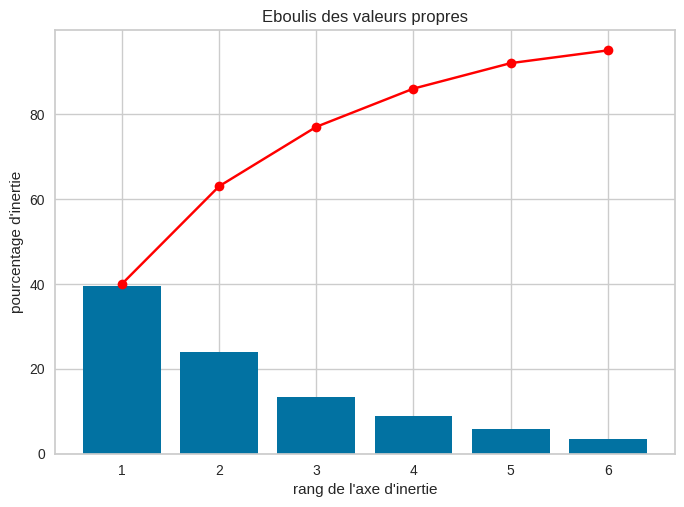

In [63]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

77 % de la variance est comprise dans les 3 premières composantes

## 3.2 - Les composantes

In [64]:
pcs = pca.components_
pcs

array([[ 0.42177036,  0.43410375,  0.13610145, -0.26696991,  0.20094562,
         0.32932562,  0.43964989,  0.28848694,  0.3442614 ],
       [ 0.06360977,  0.21122271, -0.61871037, -0.12657771,  0.36222292,
         0.41894779, -0.17893919, -0.19204278, -0.42058527],
       [-0.36487371, -0.16268805,  0.1830024 ,  0.50719003,  0.59746739,
         0.319407  , -0.0492097 ,  0.22751765,  0.19103448],
       [ 0.13042822,  0.23122958, -0.1934174 ,  0.46512817, -0.27847494,
        -0.09098523,  0.03447964,  0.67146515, -0.37132998],
       [ 0.26011309,  0.279144  ,  0.03720519,  0.64507555, -0.1220278 ,
         0.05205154,  0.22273625, -0.60516432,  0.0589718 ],
       [-0.4727812 , -0.15571395, -0.20139817, -0.06300335, -0.104407  ,
         0.06154508,  0.81005881, -0.04818095, -0.18572875]])

In [65]:
# Array des composantes convertit en df
pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5,6,7,8
0,0.421770,0.434104,0.136101,-0.266970,0.200946,0.329326,0.439650,0.288487,0.344261
1,0.063610,0.211223,-0.618710,-0.126578,0.362223,0.418948,-0.178939,-0.192043,-0.420585
2,-0.364874,-0.162688,0.183002,0.507190,0.597467,0.319407,-0.049210,0.227518,0.191034
3,0.130428,0.231230,-0.193417,0.465128,-0.278475,-0.090985,0.034480,0.671465,-0.371330
4,0.260113,0.279144,0.037205,0.645076,-0.122028,0.052052,0.222736,-0.605164,0.058972
5,-0.472781,-0.155714,-0.201398,-0.063003,-0.104407,0.061545,0.810059,-0.048181,-0.185729


In [66]:
pcs.columns = df_log.columns

pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,EoDB,Log(PIB),Log(Population),Coef_croissance,ratio_volaille,Disponibilité volaille,Log(Exportations),Importations,Log(Production)
F1,0.42,0.43,0.14,-0.27,0.20,0.33,0.44,0.29,0.34
F2,0.06,0.21,-0.62,-0.13,0.36,0.42,-0.18,-0.19,-0.42
F3,-0.36,-0.16,0.18,0.51,0.60,0.32,-0.05,0.23,0.19
F4,0.13,0.23,-0.19,0.47,-0.28,-0.09,0.03,0.67,-0.37
F5,0.26,0.28,0.04,0.65,-0.12,0.05,0.22,-0.61,0.06
F6,-0.47,-0.16,-0.20,-0.06,-0.10,0.06,0.81,-0.05,-0.19


In [67]:
#df transposé:
pcs.T

,F1,F2,F3,F4,F5,F6
EoDB,0.421770,0.063610,-0.364874,0.130428,0.260113,-0.472781
Log(PIB),0.434104,0.211223,-0.162688,0.231230,0.279144,-0.155714
Log(Population),0.136101,-0.618710,0.183002,-0.193417,0.037205,-0.201398
Coef_croissance,-0.266970,-0.126578,0.507190,0.465128,0.645076,-0.063003
ratio_volaille,0.200946,0.362223,0.597467,-0.278475,-0.122028,-0.104407
Disponibilité volaille,0.329326,0.418948,0.319407,-0.090985,0.052052,0.061545
Log(Exportations),0.439650,-0.178939,-0.049210,0.034480,0.222736,0.810059
Importations,0.288487,-0.192043,0.227518,0.671465,-0.605164,-0.048181
Log(Production),0.344261,-0.420585,0.191034,-0.371330,0.058972,-0.185729


<Axes: >

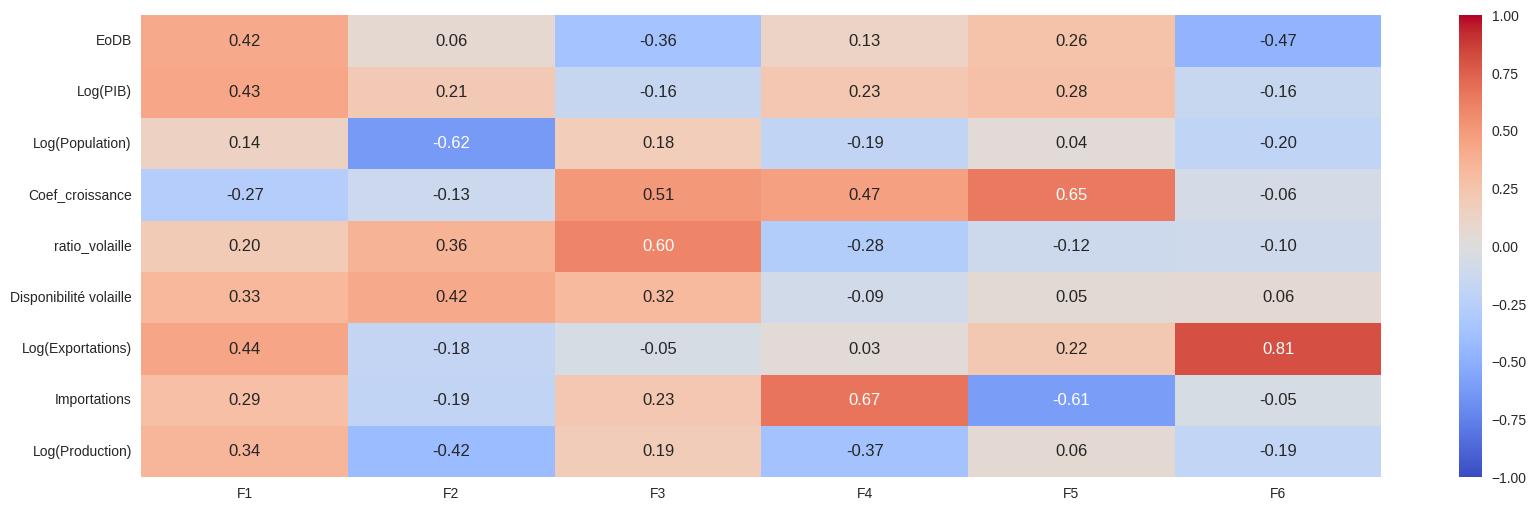

In [68]:
# représentation visuelle :
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

On peut ici regarder quelles variables contribue le plus aux premières composantes:

**1ère composante:**

contibution positive : PIB EoDB Exportation

**2ème composante:**

contibution positive : ratio, soit la proportion de volaille par rapport aux autres viandes et dispo volaille

contibution négative : Population Production

## 3.3 - Les cercles de corrélations

In [69]:
def correlation_graph(pca,
                      x_y,
                      features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [70]:
x_y = (0,1)
x_y

(0, 1)

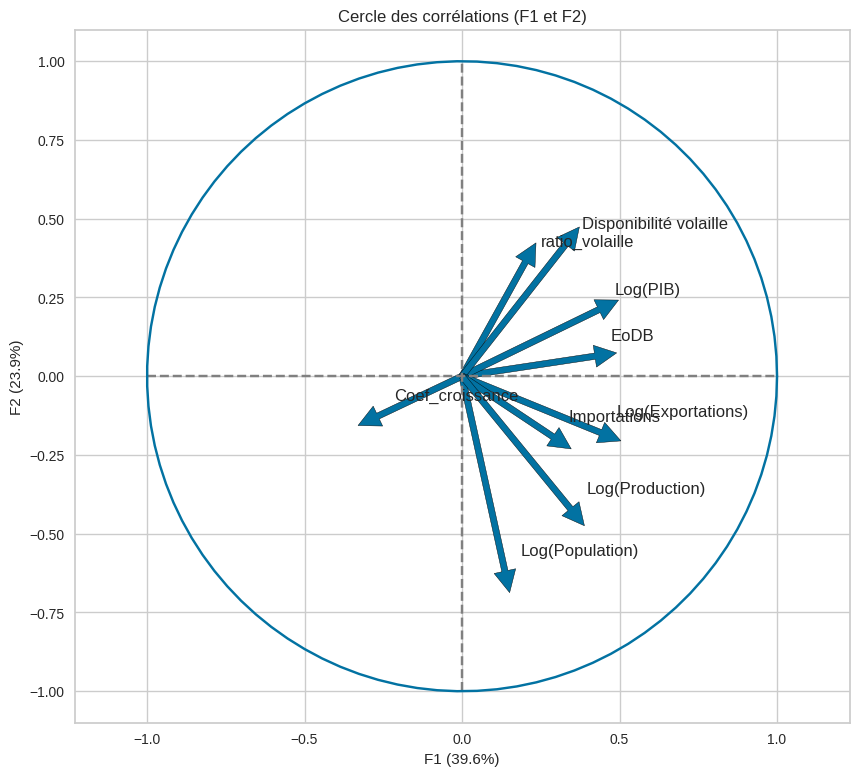

In [71]:
correlation_graph(pca, x_y, df_log.columns)

1ère composante:


*  contribution positive : PIB EoDB Exportation


2 ème composante:


*  contribution positive : ratio et dispo volaille
*  contribution négative : Population Production




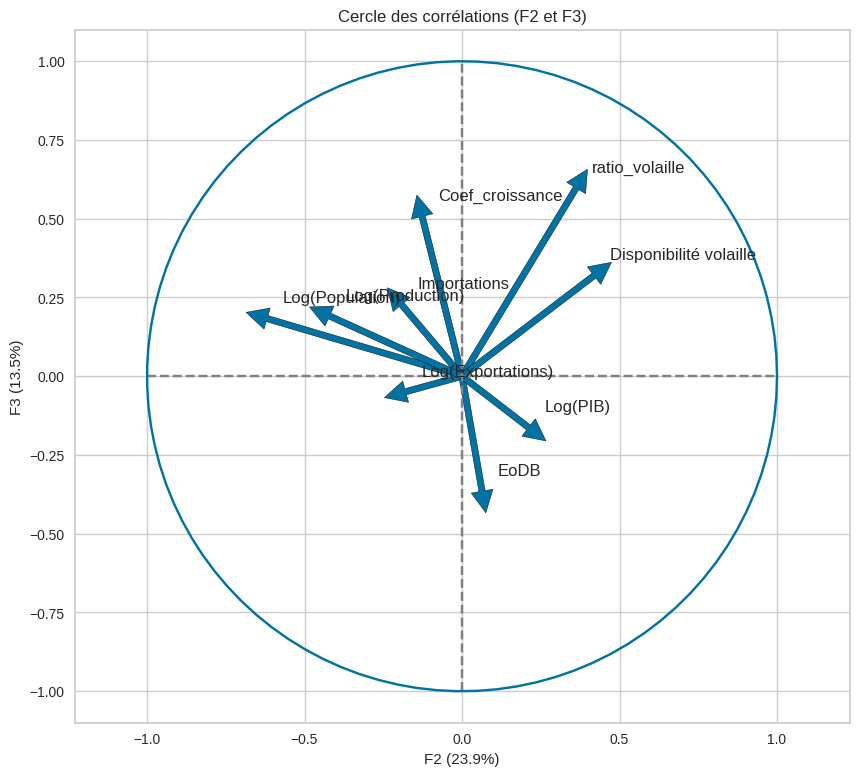

In [72]:
correlation_graph(pca, (1,2), df_log.columns)

3ème composante:


*  contribution positive : Population
*  contribution négative : (coef de croissance mais flèches trop courte ?)

2 ème composante:

*  contribution positive :Importations coef de croissanceratio et dispo volaille
*  contribution négative : Population

## 3.4 - Projection des individus sur le cercle de corrélation

In [73]:
# calcul des coordonnées de nos individus dans le nouvel espace :
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[-2.9182202 , -1.57168219,  0.85229971,  0.20389461,  0.14772579,
         0.33815524],
       [ 2.56946569, -0.8107013 ,  1.94915373,  0.40054092, -1.06755115,
         0.15578342],
       [-0.47445619,  0.86683155, -1.03799845, -0.41691224, -0.89740689,
        -0.33738112],
       [-1.09942358, -1.03810571,  0.45147232, -0.75678697, -0.13579409,
        -0.31596884],
       [ 4.09613968, -2.13069879, -0.27500052,  2.2966339 , -1.59699126,
         0.38555011]])

In [74]:
# Définition de la fonction de projection

def display_factorial_planes(   X_projected,
                                x_y,
                                pca=None,
                                labels = None,
                                clusters=None,
                                alpha=1,
                                figsize=[10,8],
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments :
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments :
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8]
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7,6)

    # On gère les labels
    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e

    # On vérifie la variable axis
    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")

    # on définit x et y
    x, y = x_y

    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters

    # Les points
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha,
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else :
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) :
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center')

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()


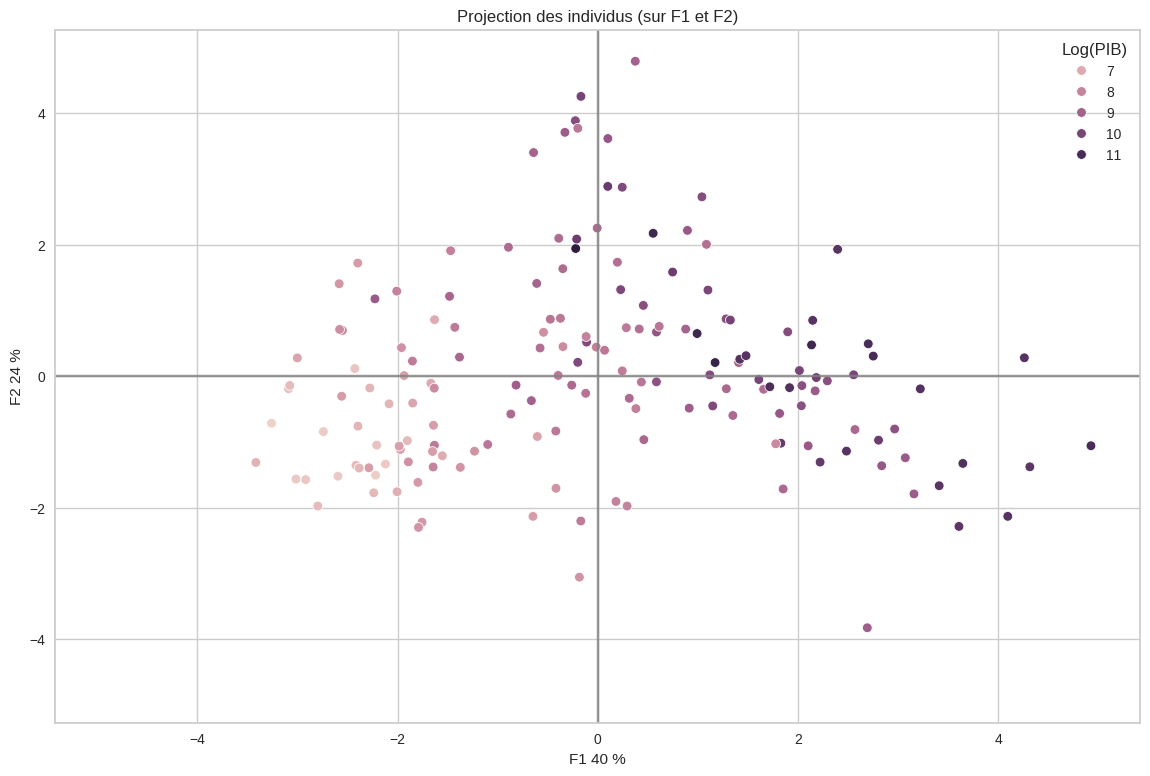

In [75]:
# Projection des individus sur le premier plan factoriel - Mise en évidence des invidus selon leur PIB, une des composantes principales de F1
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca, figsize=(14,9), clusters=df_log['Log(PIB)'], marker="o")

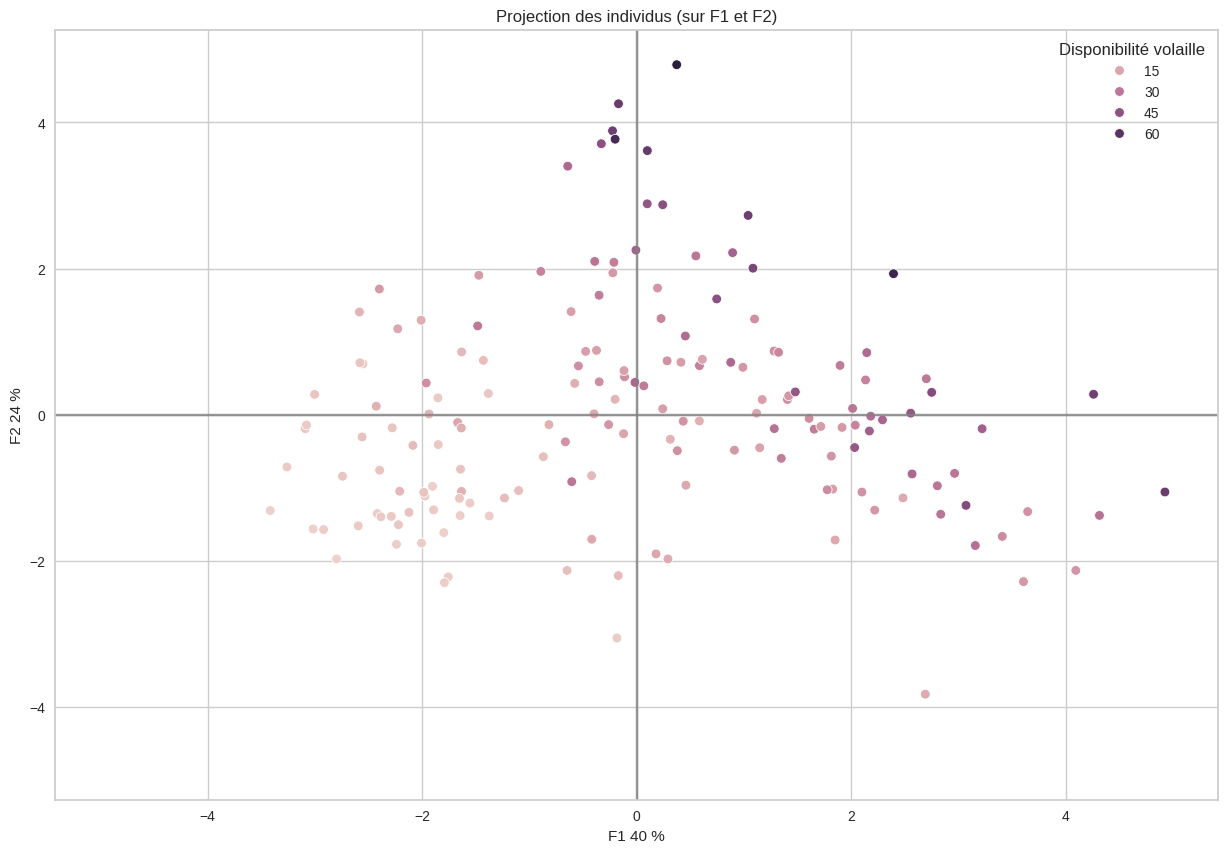

In [76]:
# Projection des individus sur le premier plan factoriel - Mise en évidence des invidus selon leur Dicponibilité en volaille, une des composantes principales de F2
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca, figsize=(15,10), clusters=df_log['Disponibilité volaille'], marker="o")

##3.5 - Projection des clusters K_means sur le cercle des corrélations

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



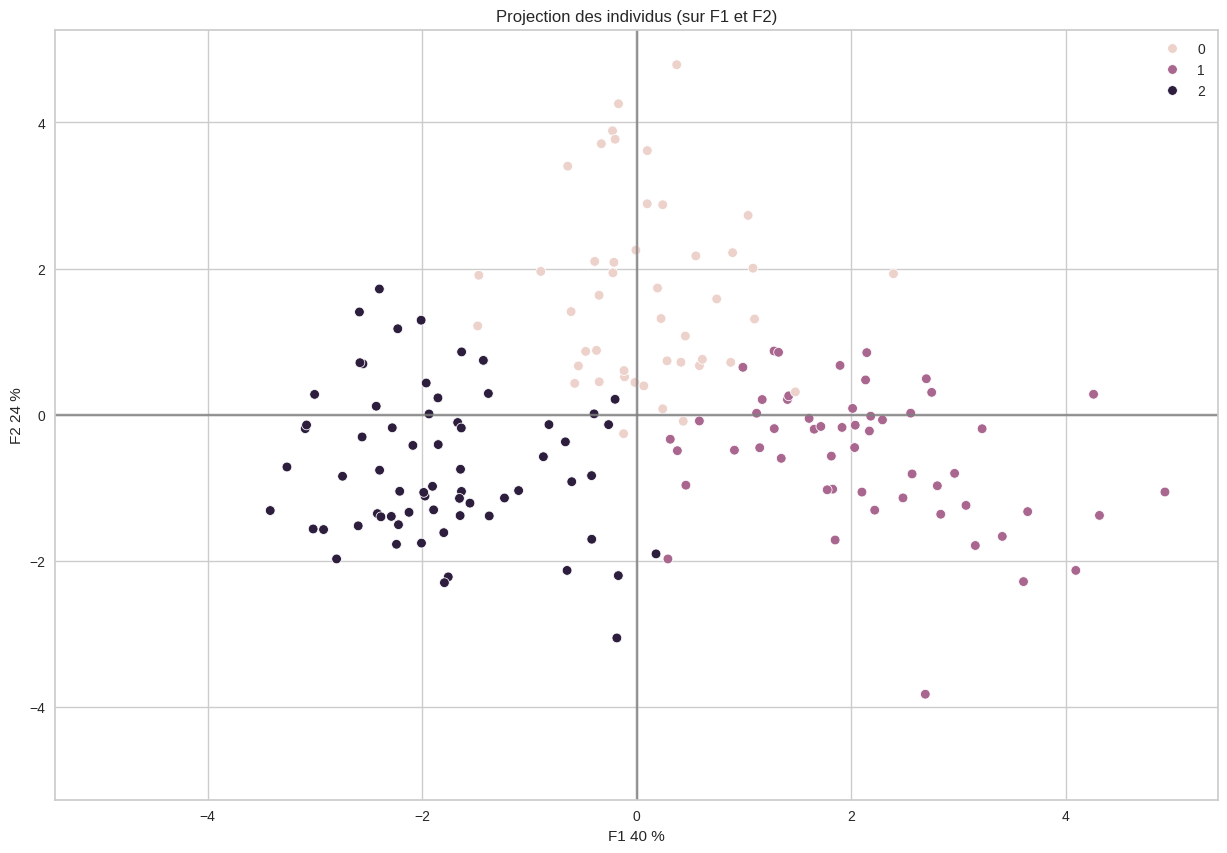

In [77]:
 #Étape 1 : Effectuer l'ACP
pca = PCA(n_components=3)  # Définir le nombre de composantes principales à conserver
X_pca = pca.fit_transform(X_scaled)  # X_scaled est votre matrice de données initiale

# Étape 2 : Appliquer K-means sur les composantes principales
kmeans = KMeans(n_clusters=3)  # Définir le nombre de clusters
kmeans.fit(X_pca)

# Étape 3 : Visualiser les clusters K-means dans l'espace réduit des composantes principales
x_y = [0, 1]
display_factorial_planes(X_pca, x_y, pca,clusters=kmeans.labels_, figsize=(15, 10), marker="o")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



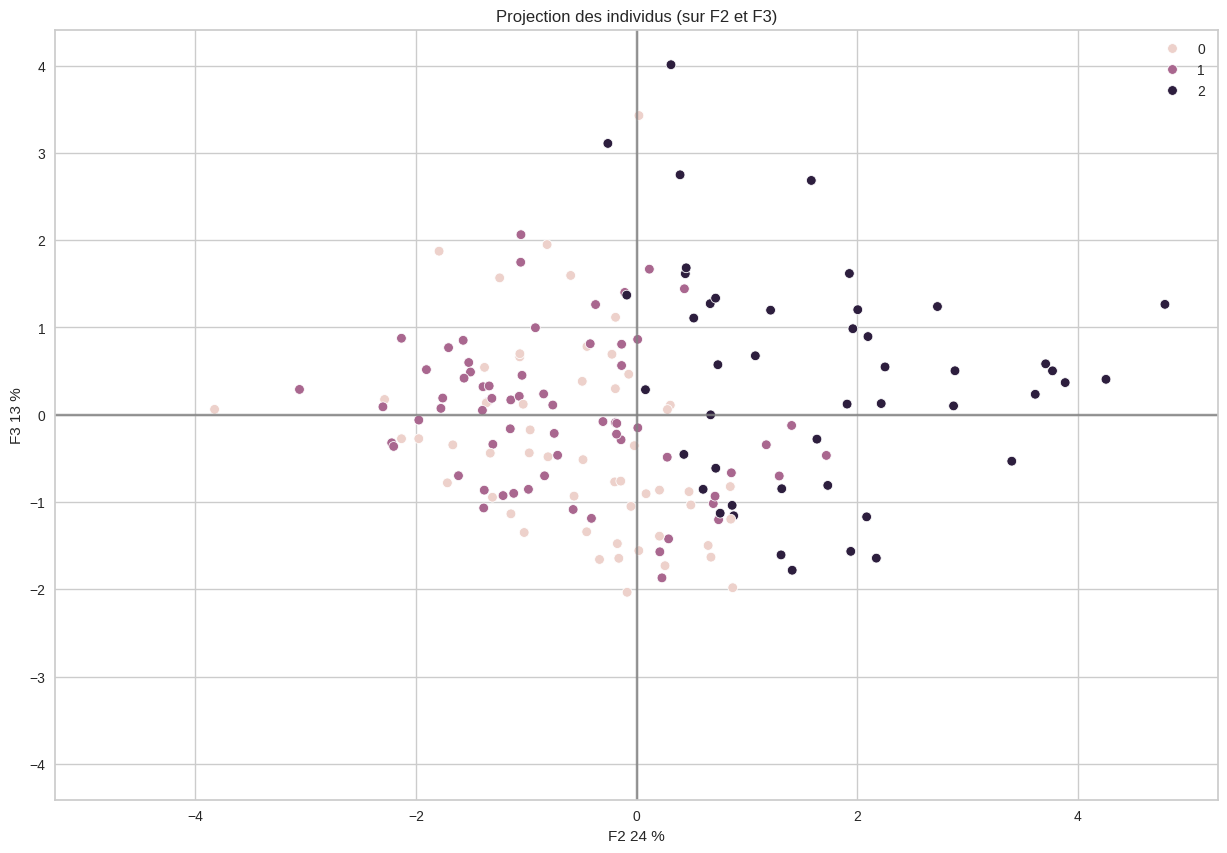

In [78]:
 #Étape 1 : Effectuer l'ACP
pca = PCA(n_components=3)  # Définir le nombre de composantes principales à conserver
X_pca = pca.fit_transform(X_scaled)  # X_scaled est votre matrice de données initiale

# Étape 2 : Appliquer K-means sur les composantes principales
kmeans = KMeans(n_clusters=3)  # Définir le nombre de clusters
kmeans.fit(X_pca)

# Étape 3 : Visualiser les clusters dans l'espace réduit des composantes principales
x_y = [1, 2]
display_factorial_planes(X_pca, x_y, pca,clusters=kmeans.labels_, figsize=(15, 10), marker="o")